In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses. Analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [4]:
from lib.config import Config
from lib.dataset_loader import DatasetLoader
from lib.model_factory import ModelFactory
from lib.data_generator import SteeringWheelAngleDataGenerator
from lib.image_preprocessor import ImagePreprocessor
from lib.sample_augmenter import SampleAugmenter
from lib.callback.callback_factory import CheckpointFactory, PlotLossesFactory
from lib.image_utils import load_image, vertical_crop_image, resize_image, rgb_to_yuv
from lib.plot_utils import show_image, show_distribution, show_sample
from lib.image_augmentation_utils import choose_image, random_image_flip, \
                                         random_image_translate, random_image_shadow, \
                                         random_image_brightness
from keras import backend as K
from keras.optimizers import Adam

**Step 2**: First of all check that has a GPU available. This is required to decrease learning training times: 

In [5]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  []


**Step 3**: Load config file.

In [6]:
cfg = Config('./config.yml')

### Load Train data

The dataset was previously generater using de **Training Mode** of UDacity simulator. This mode generate:

1. **IMG** directory that contain images taked with all cameras(left, center, right)

2. **driving_log.csv** file that contain examples with next columns:

In [7]:
cfg['dataset']['columns']

['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

When:
* **Center**, **Left** and **Right**: Are images paths. That images was taked from three cameras mounted in front of a car in the simulator.
* **Steering**: The car steering whell angle.
* **Throttle**: Car aceletation.
* **Reverse**
* **Speed**: Car speed.

**Step 1**: Load dataset

In [8]:
loader = DatasetLoader(cfg)

dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels']
)




Images


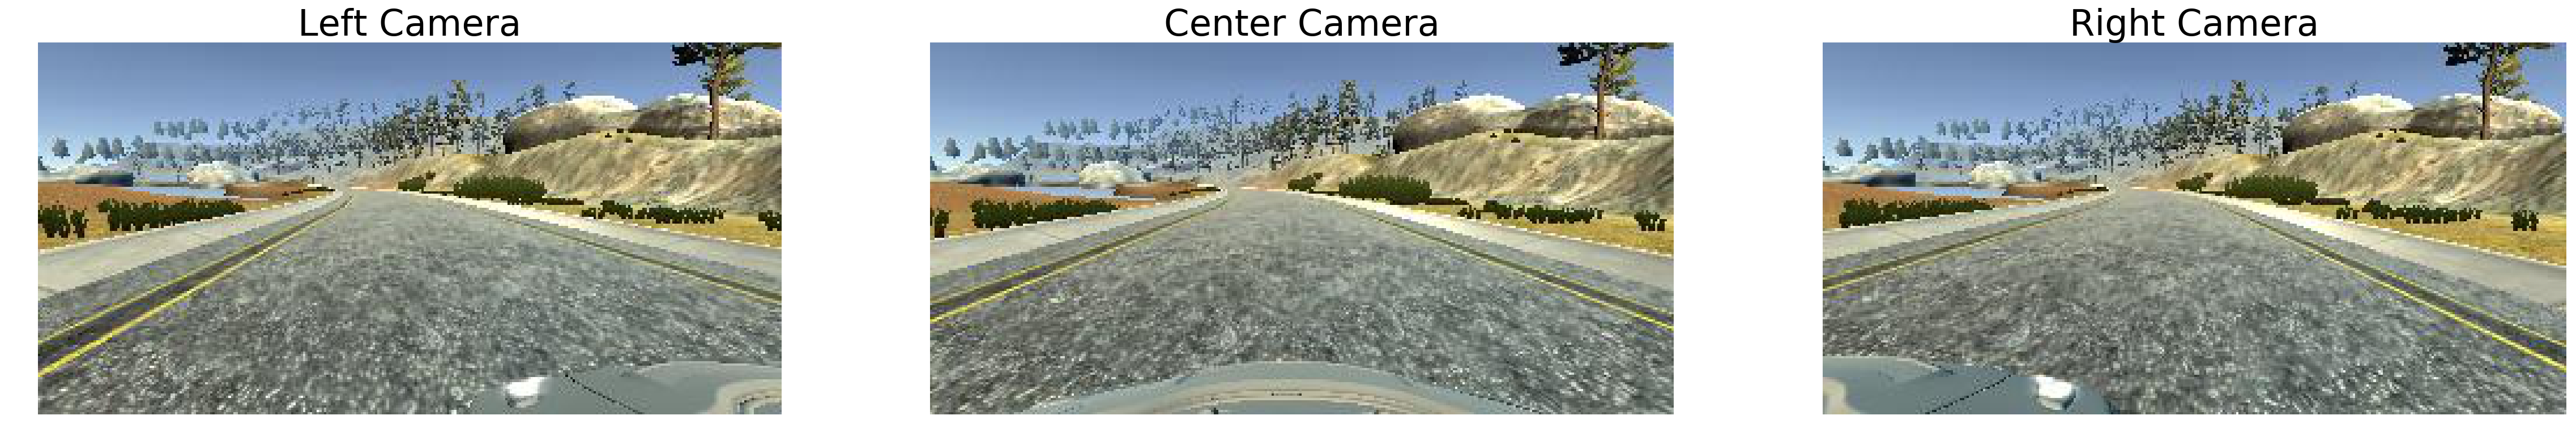

Steering Angle: 0.0




In [9]:
sample = dataset[0]
sample.show()

**Step 2**: Show streering angle distribution

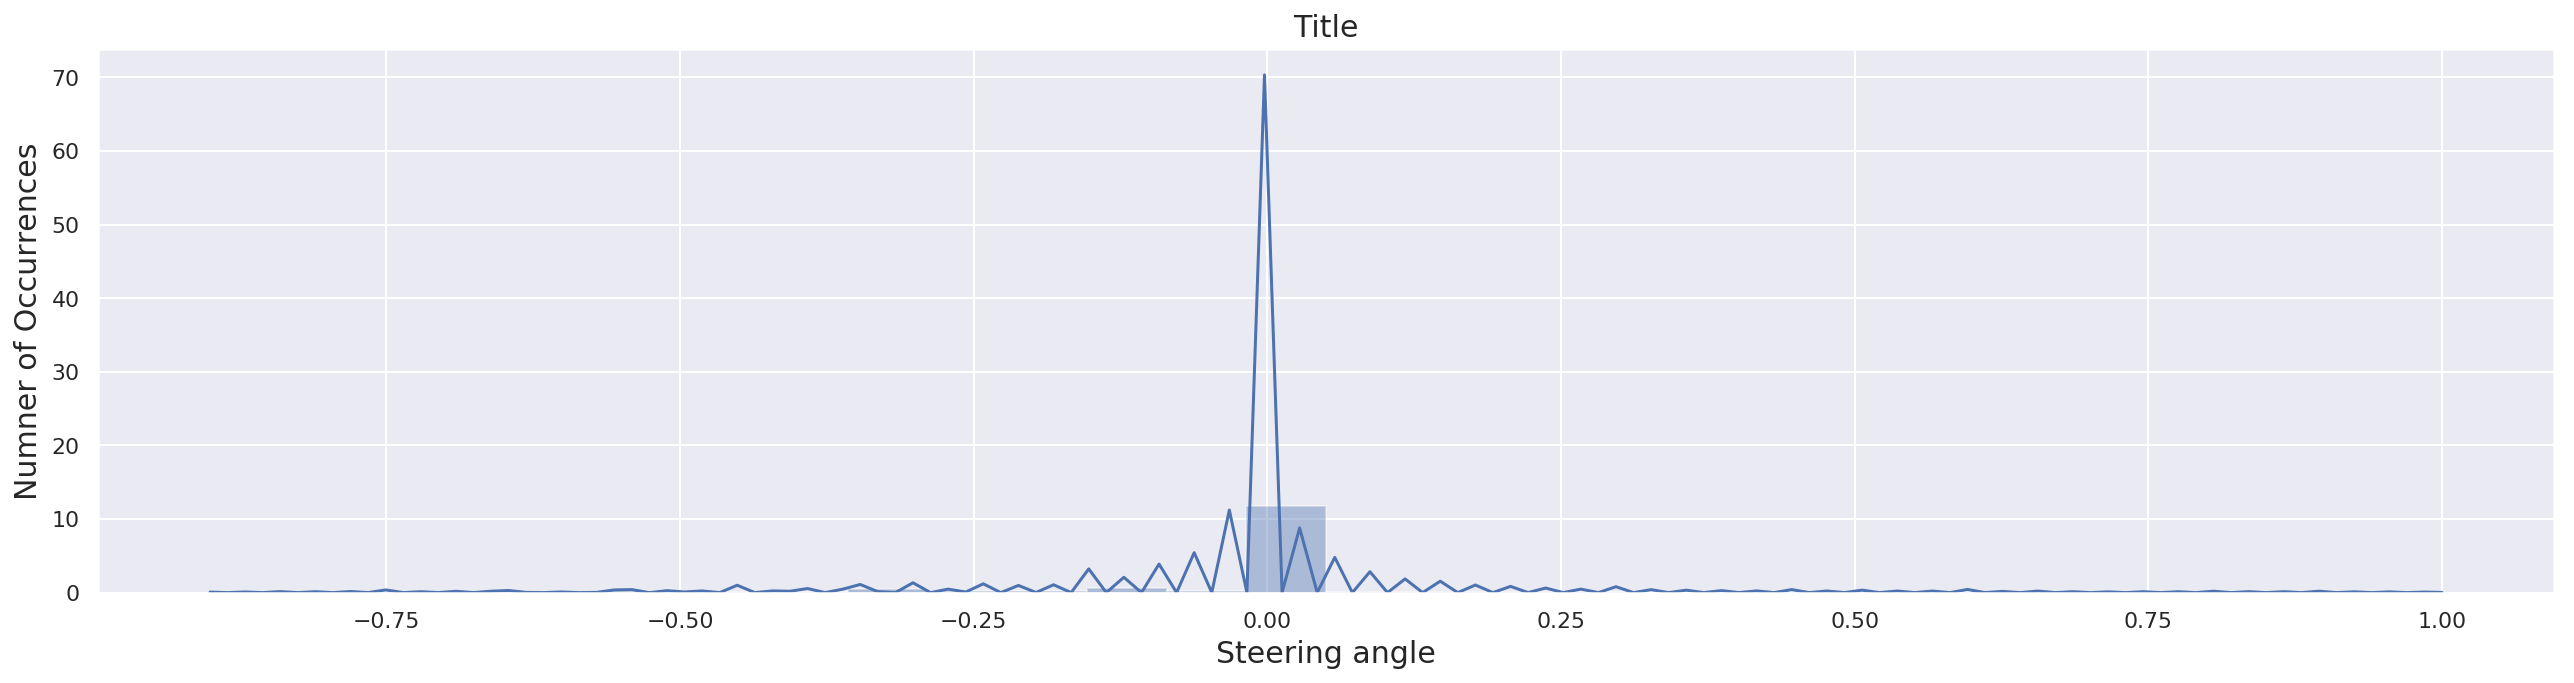

In [10]:
show_distribution(dataset)

**Step 2**: Split dataset in train and validation.

In [11]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_percent'])

In [12]:
print("Train dataset examples: ", len(train_dataset))

Train dataset examples:  651


In [13]:
print("Validation dataset examples: ", len(validation_dataset))

Validation dataset examples:  163


### Create NVidia model

The model can get as input an image and predict next steering whell angle of the car.

**Step 1:** Define magic lambda that used to normalize images to avoid saturation and make gradients work better.

In [14]:
input_normalization=lambda x: x / 127.5 - 1.0

**Step 2:** Next let's define the input shape given three parameters:

In [15]:
image_height = cfg['dataset']['image']['height']
print('Input Image Height: ', image_height)

Input Image Height:  160


In [16]:
image_width = cfg['dataset']['image']['width']
print('Input Image Width: ', image_width)

Input Image Width:  320


The image channels refers to RGB color notation (red, green, blue):

In [17]:
image_channels = cfg['dataset']['image']['channels']
print('Input Image Channels: ', image_channels)

Input Image Channels:  3


Then define input shape:

Then an input shape is a tensor (a list of matrixes) of range 3:

In [18]:
input_shape=(image_height, image_width, image_channels)
input_shape

(160, 320, 3)

**Step 3:** Next define 50% dropout after las CNN layer <a href='#1.-Dropout'>[1]</a>:

In [19]:
cnn_end_dropout_rate=0.5

**Step 4:** Also use an activation function ELU <a href='#2.-Activation-Functions'>[2]</a>:

In [20]:
activation='elu'

**Step 5:** Create the model.




MODEL LAYERS

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 33, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 33, 64)        0   

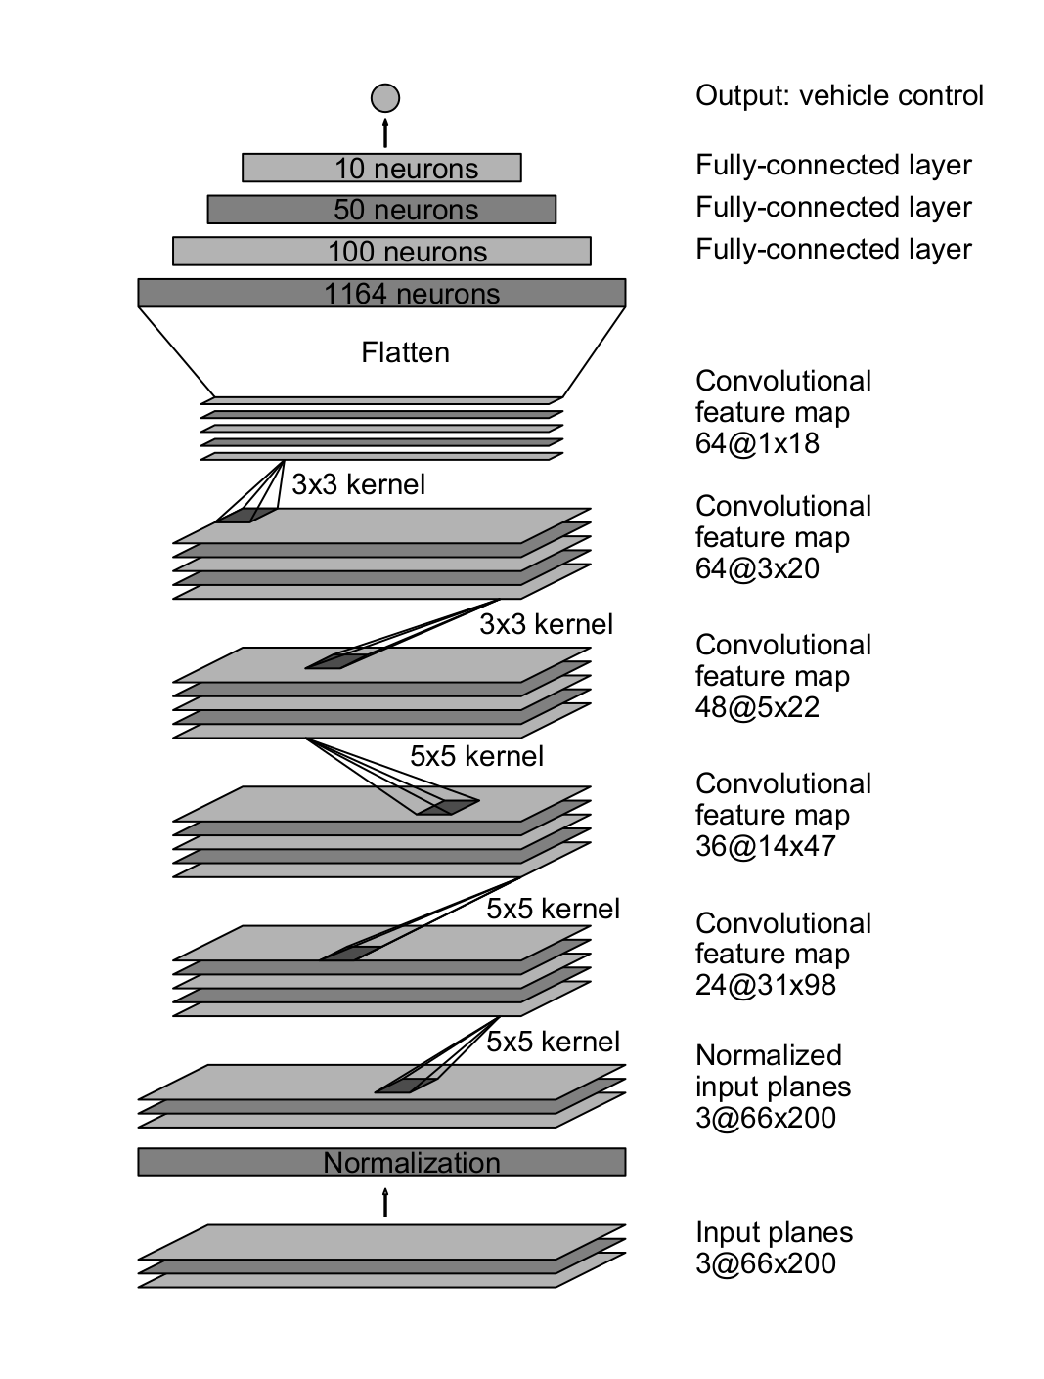

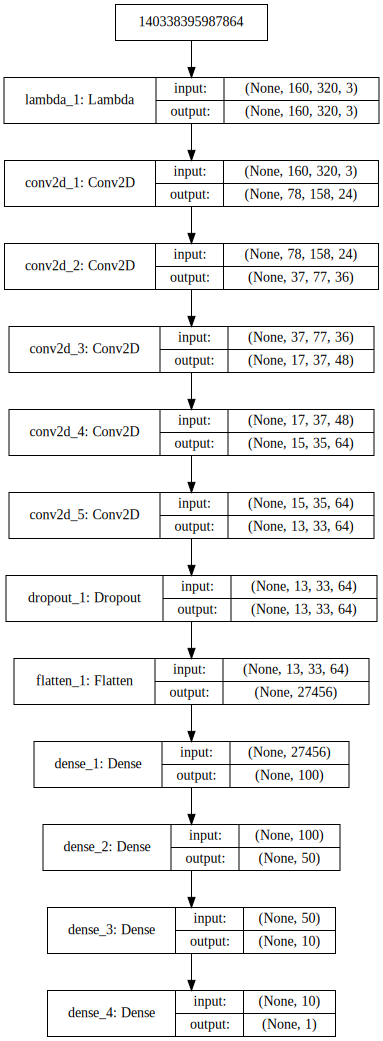

In [21]:
model = ModelFactory.create_nvidia_model(
    input_shape,
    input_normalization,
    cnn_end_dropout_rate,
    activation
)
model.show()

### Data generation process

After all is necessary explain three importante points:

* A generator allow us to generator a dataset for augment and/or preprocess and in this way increase samples amount. 
* Since in most cases dataset does not fit in memory a generator allow as to save memory space, loading only a subset of this on each train batch.
* A generator also allow us to process data using multiples cpu cores.

On the other hand, data augmentation and preprocessing is required to improve model accuracy. Particularly for this problem is required two flows to generate samples:

* **Train samples generation**:
    * Augment & preprocess a randomly image from the center, left or right cameras.
    * Preproress agmented image.
    * Steering angles is adjustes in each case.

* **Validation samples generation**: Only preprocess center camera image.

But what does augmentation and preprocess means?
        
* **Augmentation steps**: 
    1. Randomly choose an image from the center, left or right, and adjust the steering angle.
    2. Randomly flip the image left <-> right, and adjust the steering angle.
    3. Randomly shift the image vertically and horizontally (translation).
    4. Generates and adds random shadow.
    5. Randomly adjust brightness of the image.

* **Preprocessing steps**:
    1. Crop the image (removing the sky at the top and the car front at the bottom).
    2. Resize the image to the input shape used by the network model.
    3. Convert the image from RGB to YUV (This is what the NVIDIA model does).

#### Augmentation steps

Let's get a samples centrar image to show each augmentation effect:




Images


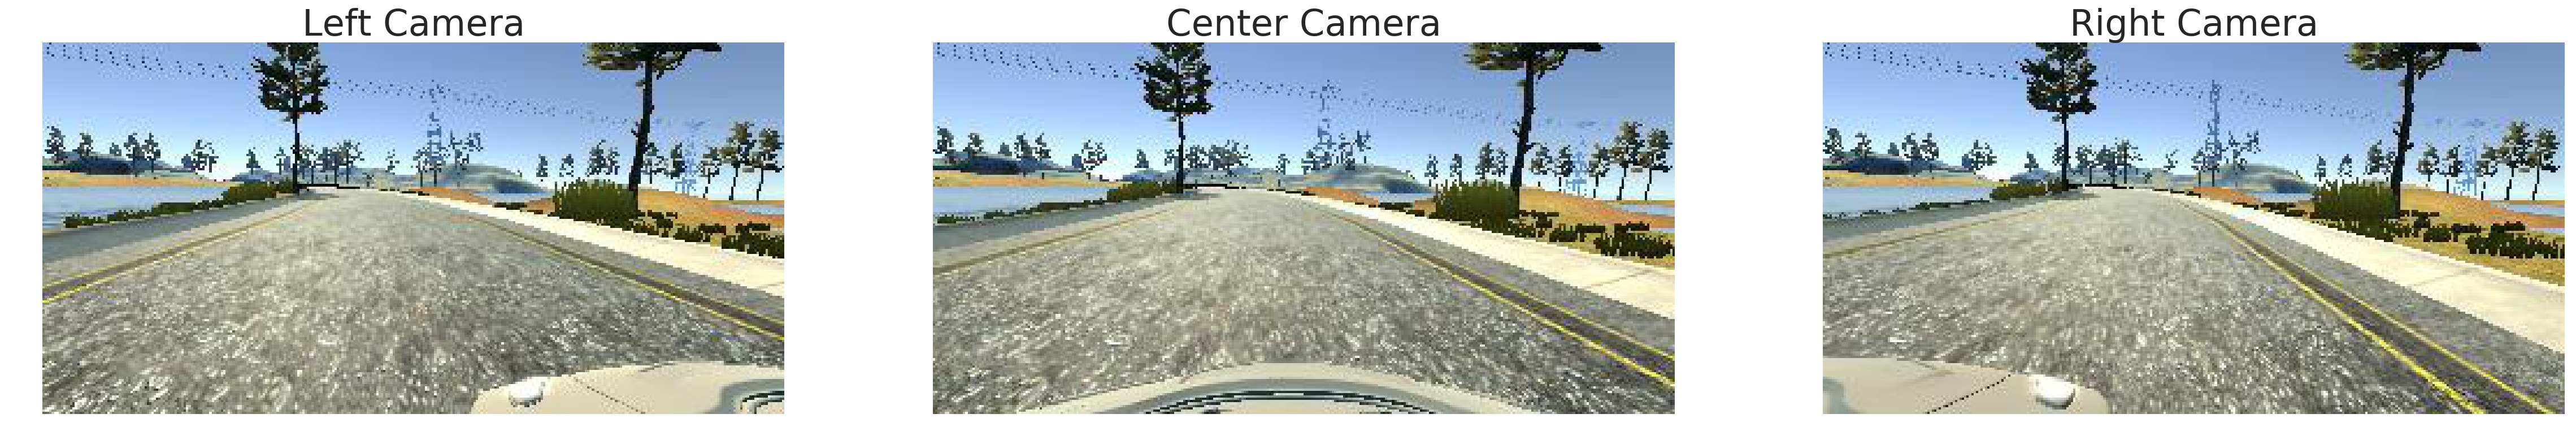

Steering Angle: 0.0




In [22]:
sample = dataset[100]
sample.show()

**Randomly choose an image**: From the center, left or right, and adjust
    the steering angle.

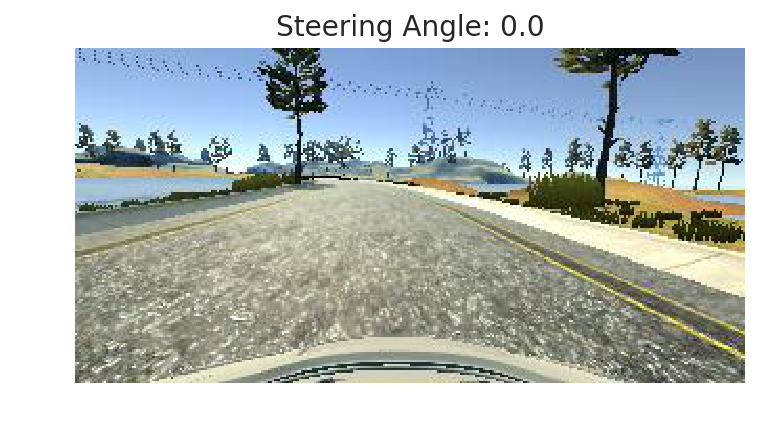

In [23]:
img, angle = choose_image(
    sample.center_image_path(), 
    sample.left_image_path(), 
    sample.right_image_path(), 
    sample.steering_angle()
)
show_sample(img, angle)

**Randomly flip image**: Randomly flip the image left <-> right, and adjust the steering angle.

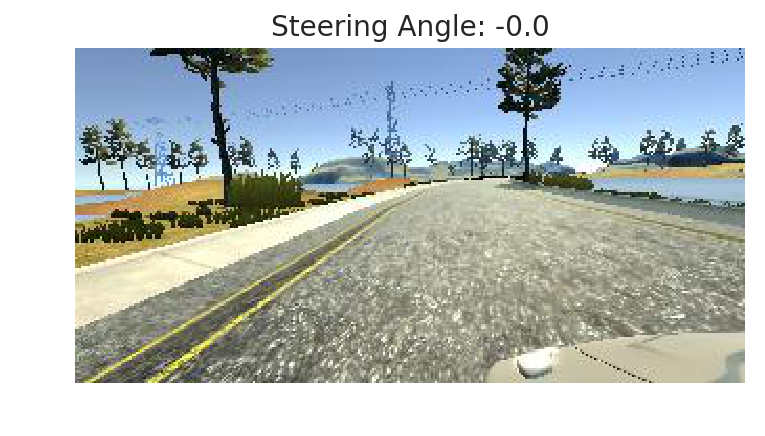

In [24]:
img, angle = random_image_flip(sample.right_image(), sample.steering_angle())
show_sample(img, angle)

**Randomly trasnlate**: Randomly shift the image vertically and horizontally.

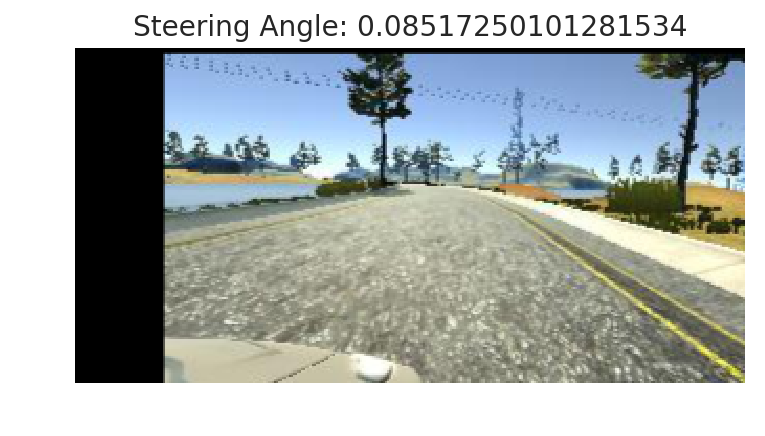

In [25]:
img, angle = random_image_translate(
    sample.right_image(), 
    sample.steering_angle(),
    range_x=100, 
    range_y=10
)
show_sample(img, angle)

**Random shadow**: Generates and adds random shadow.

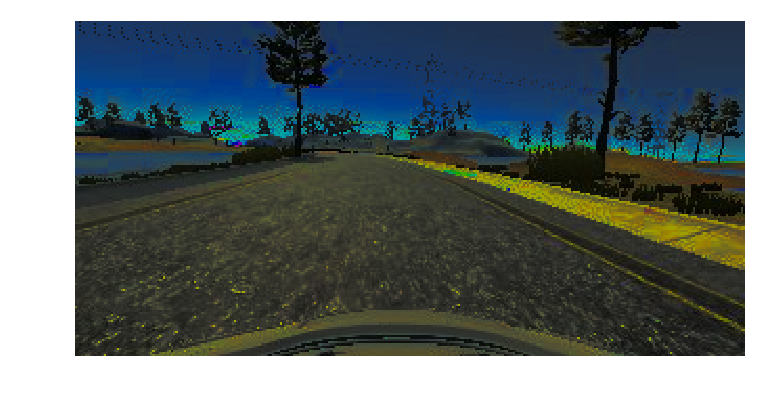

In [26]:
show_sample(random_image_shadow(sample.center_image(), width=320, height=160))

**Randomly brightness**: Randomly adjust brightness of the image.

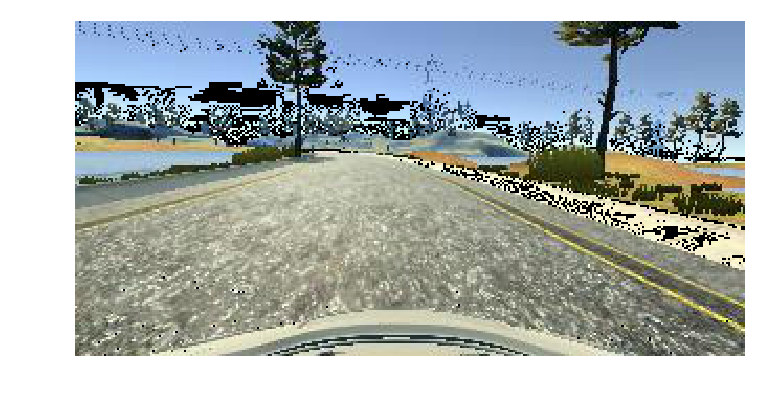

In [27]:
show_sample(random_image_brightness(sample.center_image()))

#### Preprocessing steps

Let's get a samples centrar image to show each preprocessing step:

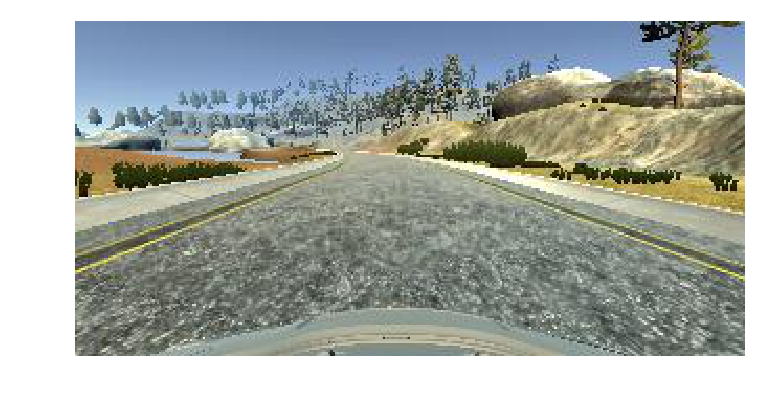

In [28]:
image = load_image(dataset[0].features[0])
show_sample(image)

**Step 1:** Randomly choose an image from the center, left or right, and adjust the steering angle.

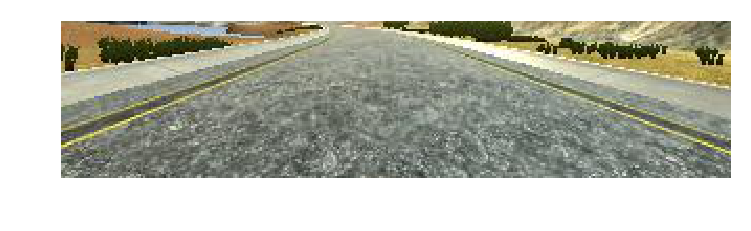

In [29]:
choped_image = vertical_crop_image(image, top_offset=60, bottom_offset=25)
show_sample(choped_image)

**Step 2**: Resize the image to the input shape used by the network model.

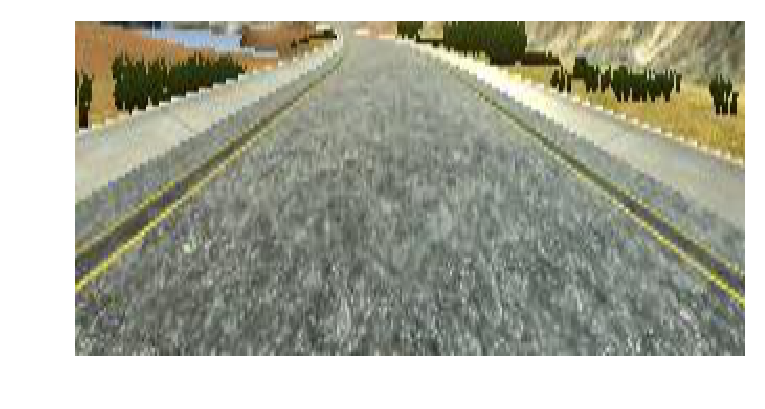

In [30]:
resized_image = resize_image(choped_image, 320, 160)
show_sample(resized_image)

**Step 3**: Convert the image from RGB to YUV (This is what the NVIDIA model does).

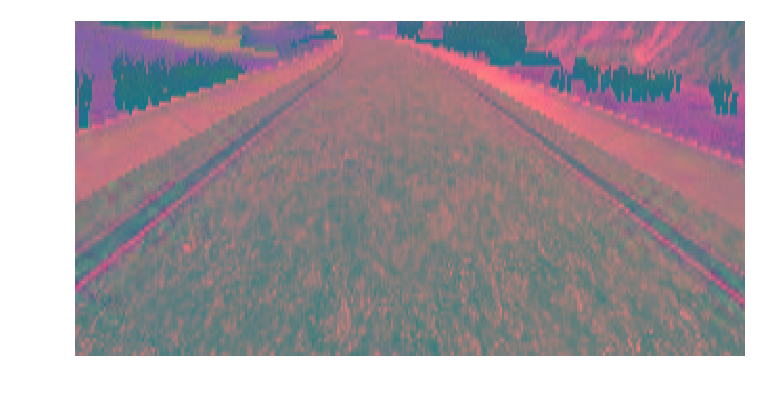

In [31]:
show_sample(rgb_to_yuv(resized_image))

#### Create train and validation data generators

In [32]:
augment_threshold = cfg['train']['augment']['threshold']
translate_range_x = cfg['train']['augment']['translate_range_x']
translate_range_y = cfg['train']['augment']['translate_range_y']
batch_size = cfg['train']['batch_size']
output_shape=[1]

In [33]:
print("Image augment threshold: ", augment_threshold)
print("Image augment translate_range_x: ", translate_range_x)
print("Image augment translate_range_y: ", translate_range_y)
print("Number of samples by batch: ", batch_size)
print("Output shape: ", output_shape)

Image augment threshold:  0.6
Image augment translate_range_x:  100
Image augment translate_range_y:  10
Number of samples by batch:  40
Output shape:  [1]


In [34]:
image_preprocessor=ImagePreprocessor(
    top_offset=60,
    bottom_offset=25,
    input_shape=input_shape
)

In [35]:
sample_augmenter = SampleAugmenter(
    augment_threshold,
    translate_range_x,
    translate_range_y
)

In [36]:
train_generator = SteeringWheelAngleDataGenerator(
    dataset=train_dataset,
    input_shape=input_shape,
    output_shape=output_shape,
    batch_size=batch_size,
    sample_augmenter=sample_augmenter,
    image_preprocessor=image_preprocessor
)

In [37]:
validation_generator = SteeringWheelAngleDataGenerator(
    dataset=validation_dataset,
    input_shape=input_shape,
    output_shape=output_shape,
    batch_size=batch_size,
    image_preprocessor=image_preprocessor
)

### Train Model

In [38]:
checkpoint_factory = CheckpointFactory(path=cfg['train']['checkpoint_path'])

checkpoint = checkpoint_factory.create(model_name=model.name, metric='val_loss')

plot_losses = PlotLossesFactory.create(
    plot_interval=1, 
    evaluate_interval=10,
    x_val=None,
    y_val_categorical=None
)
callbacks=[checkpoint]

In [39]:
optimizer=Adam(lr=1.0e-4)
model.compile(loss='mean_squared_error',optimizer=optimizer)

In [40]:
steps_per_epoch=30
epochs=10

**Steps per epoch**: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.

i.e.: When steps_per_epoch == 5 then model fit 5 baches por epoch and use 5 * batch_size samples.

**samples_per_epoch = steps_per_epoch * batch_size**


In [ ]:
model.train(
    generator=train_generator,
    validation_generator=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks
) 

Epoch 1/10
11/30 [==========>...................] - ETA: 19s - loss: 0.2664 - acc: 0.2977

### References

##### 1. Dropout

* [Dropout](https://youtu.be/Ty6K6YiGdBs)
* [Dropout RENDER](https://youtu.be/6DcImJS8uV8)
* [Dropout Pt. 2 RENDER](https://youtu.be/8nG8zzJMbZw)

##### 2. Activation Functions

* [Introduction to Exponential Linear Unit](https://medium.com/@krishnakalyan3/introduction-to-exponential-linear-unit-d3e2904b366c)
* [Which Activation Function Should I Use?](https://youtu.be/-7scQpJT7uo)

#### 3. Data Generations

* [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)